In [1]:
# Imported libraries

import os
import cv2
import csv
import pandas as pd
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import opendatasets as od

from PIL import Image
from PIL.ExifTags import TAGS

/tmp/ipykernel_38595/1602932012.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# od.download("https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset")

In [3]:
from image_data_validator import ImageDataValidator
from pathlib import Path

base_dir = "./DATA/"

directories = [
    f"{base_dir}test/Benign",
    f"{base_dir}test/Malignant",
    f"{base_dir}train/Benign",
    f"{base_dir}train/Malignant"
]

In [4]:
type(directories[0])

str

In [5]:
print(directories[0])

./DATA/test/Benign


In [6]:
path = Path(directories[0])
print(path)
if not path.exists():
    raise ValueError(f"Directory does not exist: {directories[0]}")
if not path.is_dir():
    raise ValueError(f"Path is not a directory: {directories[0]}")

print(any(file.is_file() for file in path.iterdir()))

DATA/test/Benign
True


In [4]:
validator = ImageDataValidator(images_dir=["./DATA/test/Benign"], width=225, height=225, extensions=["bueg"])
validator

In [6]:
print(validator.create_metadata.__doc__)


        Creates and stores metadata for an image based on its dimensions and class.

        Parameters:
        file_path (str): Path to the image file.

        Returns:
        None
            If successful, the method does not return a value.
        Exception
            If an error occurs while opening the file, the exception is returned.

        Notes:
        - Metadata includes the image name, width, height, and the class derived from the file path.
        - The image class is extracted as the parent directory of the file path.
        


In [5]:
validator.sizes

{'./DATA/test/Benign': 1000}

In [6]:
len(validator.dimensions)

1000

In [7]:
pd = pd.DataFrame(validator.inconsistencies)
pd

,file_path,error,issue
0,./DATA/test/Benign/6646.jpg,Invalid extension,Extension check failed
1,./DATA/test/Benign/6646.jpg,No metadata,Metadata check failed
2,./DATA/test/Benign/6646.jpg,Dimension mismatch,Dimension check failed
3,./DATA/test/Benign/6836.jpg,Invalid extension,Extension check failed
4,./DATA/test/Benign/6836.jpg,No metadata,Metadata check failed
...,...,...,...
2995,./DATA/test/Benign/6418.jpg,No metadata,Metadata check failed
2996,./DATA/test/Benign/6418.jpg,Dimension mismatch,Dimension check failed
2997,./DATA/test/Benign/7264.jpg,Invalid extension,Extension check failed
2998,./DATA/test/Benign/7264.jpg,No metadata,Metadata check failed


In [6]:
validator.images

{'./DATA/test/Benign/6646.jpg': '6646.jpg',
 './DATA/test/Benign/6836.jpg': '6836.jpg',
 './DATA/test/Benign/6654.jpg': '6654.jpg',
 './DATA/test/Benign/6713.jpg': '6713.jpg',
 './DATA/test/Benign/7041.jpg': '7041.jpg',
 './DATA/test/Benign/6788.jpg': '6788.jpg',
 './DATA/test/Benign/6987.jpg': '6987.jpg',
 './DATA/test/Benign/6827.jpg': '6827.jpg',
 './DATA/test/Benign/6948.jpg': '6948.jpg',
 './DATA/test/Benign/6904.jpg': '6904.jpg',
 './DATA/test/Benign/6737.jpg': '6737.jpg',
 './DATA/test/Benign/6350.jpg': '6350.jpg',
 './DATA/test/Benign/6437.jpg': '6437.jpg',
 './DATA/test/Benign/7100.jpg': '7100.jpg',
 './DATA/test/Benign/6723.jpg': '6723.jpg',
 './DATA/test/Benign/6859.jpg': '6859.jpg',
 './DATA/test/Benign/6401.jpg': '6401.jpg',
 './DATA/test/Benign/7289.jpg': '7289.jpg',
 './DATA/test/Benign/6597.jpg': '6597.jpg',
 './DATA/test/Benign/7113.jpg': '7113.jpg',
 './DATA/test/Benign/6897.jpg': '6897.jpg',
 './DATA/test/Benign/6362.jpg': '6362.jpg',
 './DATA/test/Benign/6954.jpg': 

In [9]:
len(validator.images_hashes)

13879

In [7]:
validator.images_hashes

{'e0b18554ae0eceada17c4892d05ee858': '6646.jpg',
 '5b19656d72b768028135f88c196e354d': '6836.jpg',
 '85c82b4af11d44955b81900dd0b0e112': '6654.jpg',
 'a599b7e32352b371620768b7cab94543': '6713.jpg',
 'c3d1b2b26243a8a54b9fecbe27f32d45': '7041.jpg',
 'ce17ce8247b8c544647a897edf3a1304': '6788.jpg',
 'e02edece54b3619fb45c8c2d3644c064': '6987.jpg',
 '85a37171df21cbf35ad2ddd17304e0ff': '6827.jpg',
 'b42fba31737bd7e6db2d1fafffc16dfa': '6948.jpg',
 'c3ca00705c49ddbcfd7c157c80945905': '6904.jpg',
 'ccdf493f9cd7468256a9e16e6fa599c8': '6737.jpg',
 'e8f93254805fba8679ae90b0731f55d2': '6350.jpg',
 '240f1390d810b8bbfb38a55ea8172e13': '6437.jpg',
 '4f6beb42a4e96d13445bcc2384bef4b9': '7100.jpg',
 'a16273d32b02835959c42f9263a926a2': '6723.jpg',
 'eaf42f49bd225128ac1f19d2ca07a56a': '6859.jpg',
 'a3cc062466ce1d5a392af486c36f8545': '6401.jpg',
 '271270caefd152023d6b06c45bc21b3f': '7289.jpg',
 'a36c2cc5f65e087da0aadad89504144d': '6597.jpg',
 'e975d77c47dda9d874f9d6a18cb16a32': '7113.jpg',
 '36aba242f6904c949f

In [8]:
validator.sizes

{'./DATA/test/Benign': 1000,
 './DATA/test/Malignant': 1000,
 './DATA/train/Benign': 6289,
 './DATA/train/Malignant': 5590}

In [8]:
len(validator.images_hashes)

13879

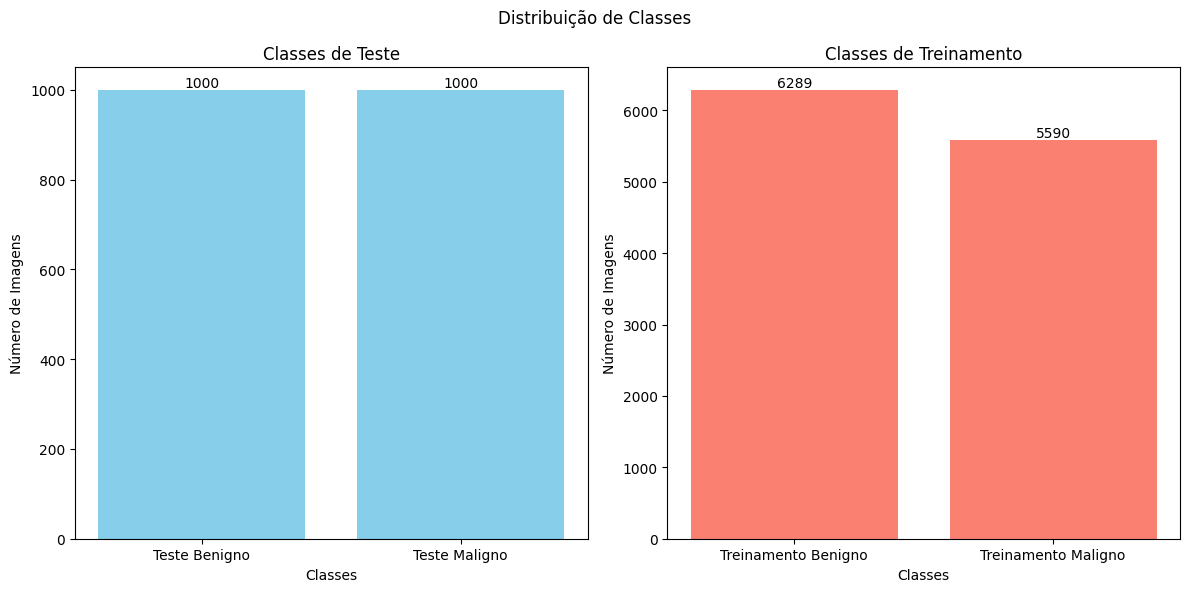

In [12]:
def plot_class_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].bar(classes[:2], counts[:2], color='skyblue')
    axs[0].set_title('Classes de Teste')
    axs[0].set_xlabel('Classes')
    axs[0].set_ylabel('Número de Imagens')
    axs[0].set_xticks(range(len(classes[:2])))
    axs[0].set_xticklabels(['Teste Benigno', 'Teste Maligno'])

    axs[1].bar(classes[2:], counts[2:], color='salmon')
    axs[1].set_title('Classes de Treinamento')
    axs[1].set_xlabel('Classes')
    axs[1].set_ylabel('Número de Imagens')
    axs[1].set_xticks(range(len(classes[2:])))
    axs[1].set_xticklabels(['Treinamento Benigno', 'Treinamento Maligno'])

    for ax in axs:
        for i, count in enumerate(counts[:2] if ax == axs[0] else counts[2:]):
            ax.text(i, count, str(count), ha='center', va='bottom')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(validator.sizes, 'Distribuição de Classes')

In [7]:
validator.check_dimension(file_path="./DATA/test/Malignant/5602.jpg", width=225, height=225)

False

In [7]:
validator.create_metadata("./DATA/test/Malignant/rabo.jpg")

FileNotFoundError(2, 'No such file or directory')

In [8]:
validator.check_metadata("./DATA/20221026_172518.jpg")

(True,
 {256: 3264,
  513: 782,
  514: 18949,
  259: 6,
  257: 1836,
  296: 2,
  34665: 261,
  271: 'samsung',
  272: 'SM-A715F',
  305: 'A715FXXU8CVD1',
  274: 1,
  306: '2022:10:26 17:25:19',
  531: 1,
  282: 72.0,
  283: 72.0,
  36864: '0220',
  40961: 1,
  37378: 2.27,
  40963: 1836,
  37380: 0.0,
  37381: 2.27,
  36867: '2022:10:26 17:25:19',
  41987: 0,
  41986: 0,
  37385: 0,
  40962: 3264,
  41989: 31,
  41988: 1.23,
  36868: '2022:10:26 17:25:19',
  37386: 3.75,
  37383: 2,
  36880: '-03:00',
  36881: '-03:00',
  37377: 0.06666666666666667,
  33434: 0.0666,
  33437: 2.2,
  42016: 'A64QLMD01MM',
  34850: 2,
  34855: 1250,
  37384: 0,
  41990: 0})

In [6]:
validator.check_quality("./DATA/test/Benign/6299.jpg")

True

In [9]:
validator.check_extension("./DATA/test/Benign/6299.jpg", ["png"])

False

In [38]:
images = validator._load_images()
images

{'./DATA/test/Benign/6646.jpg': '6646.jpg',
 './DATA/test/Benign/6836.jpg': '6836.jpg',
 './DATA/test/Benign/6654.jpg': '6654.jpg',
 './DATA/test/Benign/6713.jpg': '6713.jpg',
 './DATA/test/Benign/7041.jpg': '7041.jpg',
 './DATA/test/Benign/6788.jpg': '6788.jpg',
 './DATA/test/Benign/6987.jpg': '6987.jpg',
 './DATA/test/Benign/6827.jpg': '6827.jpg',
 './DATA/test/Benign/6948.jpg': '6948.jpg',
 './DATA/test/Benign/6904.jpg': '6904.jpg',
 './DATA/test/Benign/6737.jpg': '6737.jpg',
 './DATA/test/Benign/6350.jpg': '6350.jpg',
 './DATA/test/Benign/6437.jpg': '6437.jpg',
 './DATA/test/Benign/7100.jpg': '7100.jpg',
 './DATA/test/Benign/6723.jpg': '6723.jpg',
 './DATA/test/Benign/6859.jpg': '6859.jpg',
 './DATA/test/Benign/6401.jpg': '6401.jpg',
 './DATA/test/Benign/7289.jpg': '7289.jpg',
 './DATA/test/Benign/6597.jpg': '6597.jpg',
 './DATA/test/Benign/7113.jpg': '7113.jpg',
 './DATA/test/Benign/6897.jpg': '6897.jpg',
 './DATA/test/Benign/6362.jpg': '6362.jpg',
 './DATA/test/Benign/6954.jpg': 

In [40]:
len(images)

13879

In [ ]:
# Formatos esperados
expected_formats = ['jpeg']

# Função para verificar imagens em um diretório
def verify_images(directory):
    missing_images = []
    incorrect_format_images = []
    total_images = 0

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            print(f"Diretório {class_dir} não encontrado.")
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            total_images += 1
            image_path = os.path.join(class_dir, image_name)
            
            # Verificar se o arquivo realmente existe
            if not os.path.exists(image_path):
                missing_images.append(image_name)
                continue
            
            # Verificar o formato da imagem
            image_format = imghdr.what(image_path)
            if image_format not in expected_formats:
                incorrect_format_images.append(image_name)
    
    return missing_images, incorrect_format_images, total_images

# Verificar diretórios de treino e teste
missing_train, incorrect_format_train, total_train = verify_images(train_dir)
missing_test, incorrect_format_test, total_test = verify_images(test_dir)

# Exibir resultados
print(f'Total de imagens na pasta treino: {total_train}')
print(f'Total de imagens na pasta teste: {total_test}')

if len(missing_train) == 0:
    print("Não há imagens ausentes na pasta de treino.")
else:
    print(f"Imagens ausentes na pasta de treino: {missing_train}")

if len(missing_test) == 0:
    print("Não há imagens ausentes na pasta de teste.")
else:
    print(f"Imagens ausentes na pasta de teste: {missing_test}")

if len(incorrect_format_train) == 0:
    print("Todas as imagens na pasta de treino estão no formato correto.")
else:
    print(f"Imagens com formato incorreto na pasta de treino: {incorrect_format_train}")

if len(incorrect_format_test) == 0:
    print("Todas as imagens na pasta de teste estão no formato correto.")
else:
    print(f"Imagens com formato incorreto na pasta de teste: {incorrect_format_test}")


Podemos concluir que o total de arquivos contidos dentro do diretório é igual ao total de imagens, como tambem podemos afirmar que todas elas estão em "jpeg", assim como tambem não há imagens ausentes.

#### Verificando dimensões

Precisamos verificar as dimensões das imagens para saber se estão consistentes.

In [5]:
for directory in directories:
    print(f"Verifying images in directory: {directory}")
    file_names = os.listdir(directory)
    
    for file_name in file_names:
        extract_exif_metadata(f"{directory}/{file_name}")
        print(file_name)

Verifying images in directory: ./DATA/test/Benign
No EXIF metadata found in: ./DATA/test/Benign/6646.jpg

6646.jpg
No EXIF metadata found in: ./DATA/test/Benign/6836.jpg

6836.jpg
No EXIF metadata found in: ./DATA/test/Benign/6654.jpg

6654.jpg
No EXIF metadata found in: ./DATA/test/Benign/6713.jpg

6713.jpg
No EXIF metadata found in: ./DATA/test/Benign/7041.jpg

7041.jpg
No EXIF metadata found in: ./DATA/test/Benign/6788.jpg

6788.jpg
No EXIF metadata found in: ./DATA/test/Benign/6987.jpg

6987.jpg
No EXIF metadata found in: ./DATA/test/Benign/6827.jpg

6827.jpg
No EXIF metadata found in: ./DATA/test/Benign/6948.jpg

6948.jpg
No EXIF metadata found in: ./DATA/test/Benign/6904.jpg

6904.jpg
No EXIF metadata found in: ./DATA/test/Benign/6737.jpg

6737.jpg
No EXIF metadata found in: ./DATA/test/Benign/6350.jpg

6350.jpg
No EXIF metadata found in: ./DATA/test/Benign/6437.jpg

6437.jpg
No EXIF metadata found in: ./DATA/test/Benign/7100.jpg

7100.jpg
No EXIF metadata found in: ./DATA/test/B

In [6]:
def get_image_dimensions(directory):
    dimensions = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })  
            except Exception:
                continue

    return dimensions

def calculate_statistics(dimensions):
    widths, heights = zip(*[(dim['width'], dim['height']) for dim in dimensions]) if dimensions else ([], [])
    mean_width = np.mean(widths) if widths else 0
    mean_height = np.mean(heights) if heights else 0
    std_width = np.std(widths) if widths else 0
    std_height = np.std(heights) if heights else 0
    
    return (mean_width, std_width, mean_height, std_height)

def verify_image_dimensions(directory, mean_width, std_width, mean_height, std_height):
    inconsistent_metadata_images = []
    dimensions = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Verificar se a largura e a altura estão dentro de 2 desvios padrão da média
                    if (abs(width - mean_width) > 2 * std_width) or (abs(height - mean_height) > 2 * std_height):
                        inconsistent_metadata_images.append(image_name)
                    
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })
            except Exception:
                inconsistent_metadata_images.append(image_name)
    
    return inconsistent_metadata_images, pd.DataFrame(dimensions)

# Coletar dimensões das imagens
train_dimensions = get_image_dimensions(train_dir)
test_dimensions = get_image_dimensions(test_dir)

# Calcular estatísticas para o conjunto de treino
mean_width, std_width, mean_height, std_height = calculate_statistics(train_dimensions)

# Verificar dimensões das imagens nos diretórios de treino e teste
inconsistent_metadata_train, train_df = verify_image_dimensions(train_dir, mean_width, std_width, mean_height, std_height)
inconsistent_metadata_test, test_df = verify_image_dimensions(test_dir, mean_width, std_width, mean_height, std_height)

# Exibir resultados
print(f"Inconsistências nos metadados das imagens na pasta de treino: {inconsistent_metadata_train}")
print(f"Inconsistências nos metadados das imagens na pasta de teste: {inconsistent_metadata_test}")

# Exibir tabelas com dimensões das imagens
print("\nDimensões das imagens na pasta de treino:")
display(train_df.head())

print("\nDimensões das imagens na pasta de teste:")
display(test_df.head())


Inconsistências nos metadados das imagens na pasta de treino: []
Inconsistências nos metadados das imagens na pasta de teste: []

Dimensões das imagens na pasta de treino:


,image_name,width,height,class
0,5025.jpg,224,224,Benign
1,3089.jpg,224,224,Benign
2,4177.jpg,224,224,Benign
3,4900.jpg,224,224,Benign
4,1560.jpg,224,224,Benign



Dimensões das imagens na pasta de teste:


,image_name,width,height,class
0,6646.jpg,224,224,Benign
1,6836.jpg,224,224,Benign
2,6654.jpg,224,224,Benign
3,6713.jpg,224,224,Benign
4,7041.jpg,224,224,Benign


#### Verificando dimensões

In [7]:
display(train_df.describe())
display(test_df.describe())

,width,height
count,11879.0,11879.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


,width,height
count,2000.0,2000.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


In [9]:
print(f'A Quantidade de imagens com metadados inconsistentes na pasta de treino é de: {len(inconsistent_metadata_train)}')
print(f'A Quantidade de imagens com metadados inconsistentes na pasta de teste é de: {len(inconsistent_metadata_test)}')

A Quantidade de imagens com metadados inconsistentes na pasta de treino é de: 0
A Quantidade de imagens com metadados inconsistentes na pasta de teste é de: 0


In [10]:

def get_image_dimensions(directory):
    dimensions = []
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })
            except Exception:
                continue

    return dimensions

def calculate_statistics(dimensions):
    widths, heights = zip(*[(dim['width'], dim['height']) for dim in dimensions]) if dimensions else ([], [])
    mean_width = np.mean(widths) if widths else 0
    mean_height = np.mean(heights) if heights else 0
    std_width = np.std(widths) if widths else 0
    std_height = np.std(heights) if heights else 0
    
    return (mean_width, std_width, mean_height, std_height)

def verify_image_dimensions(directory, mean_width, std_width, mean_height, std_height):
    inconsistent_metadata_images = []
    dimensions = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Verificar se a largura e a altura estão dentro de 2 desvios padrão da média
                    if (abs(width - mean_width) > 2 * std_width) or (abs(height - mean_height) > 2 * std_height):
                        inconsistent_metadata_images.append(image_name)
                    
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })
            except Exception:
                inconsistent_metadata_images.append(image_name)
    
    return inconsistent_metadata_images, pd.DataFrame(dimensions)

# Coletar dimensões das imagens
train_dimensions = get_image_dimensions(train_dir)
test_dimensions = get_image_dimensions(test_dir)

# Calcular estatísticas para o conjunto de treino
mean_width, std_width, mean_height, std_height = calculate_statistics(train_dimensions)

# Verificar dimensões das imagens nos diretórios de treino e teste
inconsistent_metadata_train, train_df = verify_image_dimensions(train_dir, mean_width, std_width, mean_height, std_height)
inconsistent_metadata_test, test_df = verify_image_dimensions(test_dir, mean_width, std_width, mean_height, std_height)

# Exibir resultados
print(f"Inconsistências nos metadados das imagens na pasta de treino: {inconsistent_metadata_train}")
print(f"Inconsistências nos metadados das imagens na pasta de teste: {inconsistent_metadata_test}")

# Exibir tabelas com dimensões das imagens
print("\nDimensões das imagens na pasta de treino:")
print(train_df.head())

print("\nDimensões das imagens na pasta de teste:")
print(test_df.head())


Inconsistências nos metadados das imagens na pasta de treino: []
Inconsistências nos metadados das imagens na pasta de teste: []

Dimensões das imagens na pasta de treino:
  image_name  width  height   class
0   5025.jpg    224     224  Benign
1   3089.jpg    224     224  Benign
2   4177.jpg    224     224  Benign
3   4900.jpg    224     224  Benign
4   1560.jpg    224     224  Benign

Dimensões das imagens na pasta de teste:
  image_name  width  height   class
0   6646.jpg    224     224  Benign
1   6836.jpg    224     224  Benign
2   6654.jpg    224     224  Benign
3   6713.jpg    224     224  Benign
4   7041.jpg    224     224  Benign


In [11]:
def get_image_dimensions(directory):
    dimensions = []
    missing_images = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })
            except Exception:
                missing_images.append(image_name)

    return dimensions, missing_images

def calculate_statistics(dimensions):
    widths, heights = zip(*[(dim['width'], dim['height']) for dim in dimensions]) if dimensions else ([], [])
    mean_width = np.mean(widths) if widths else 0
    mean_height = np.mean(heights) if heights else 0
    std_width = np.std(widths) if widths else 0
    std_height = np.std(heights) if heights else 0
    
    return (mean_width, std_width, mean_height, std_height)

def verify_image_dimensions(directory, mean_width, std_width, mean_height, std_height):
    inconsistent_metadata_images = []
    dimensions = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Verificar se a largura e a altura estão dentro de 2 desvios padrão da média
                    if (abs(width - mean_width) > 2 * std_width) or (abs(height - mean_height) > 2 * std_height):
                        inconsistent_metadata_images.append(image_name)
                    
                    dimensions.append({
                        'image_name': image_name,
                        'width': width,
                        'height': height,
                        'class': class_name
                    })
            except Exception:
                inconsistent_metadata_images.append(image_name)
    
    return inconsistent_metadata_images, pd.DataFrame(dimensions)

# Coletar dimensões das imagens e valores ausentes
train_dimensions, missing_train_images = get_image_dimensions(train_dir)
test_dimensions, missing_test_images = get_image_dimensions(test_dir)

# Calcular estatísticas para o conjunto de treino
mean_width, std_width, mean_height, std_height = calculate_statistics(train_dimensions)

# Verificar dimensões das imagens nos diretórios de treino e teste
inconsistent_metadata_train, train_df = verify_image_dimensions(train_dir, mean_width, std_width, mean_height, std_height)
inconsistent_metadata_test, test_df = verify_image_dimensions(test_dir, mean_width, std_width, mean_height, std_height)

# Exibir resultados
print(f"Imagens ausentes na pasta de treino: {missing_train_images}")
print(f"Imagens ausentes na pasta de teste: {missing_test_images}")

print(f"Inconsistências nos metadados das imagens na pasta de treino: {inconsistent_metadata_train}")
print(f"Inconsistências nos metadados das imagens na pasta de teste: {inconsistent_metadata_test}")

# Exibir tabelas com dimensões das imagens
print("\nDimensões das imagens na pasta de treino:")
print(train_df.head())
display(train_df.describe())


print("\nDimensões das imagens na pasta de teste:")
print(test_df.head())
display(test_df.describe())


Imagens ausentes na pasta de treino: []
Imagens ausentes na pasta de teste: []
Inconsistências nos metadados das imagens na pasta de treino: []
Inconsistências nos metadados das imagens na pasta de teste: []

Dimensões das imagens na pasta de treino:
  image_name  width  height   class
0   5025.jpg    224     224  Benign
1   3089.jpg    224     224  Benign
2   4177.jpg    224     224  Benign
3   4900.jpg    224     224  Benign
4   1560.jpg    224     224  Benign


,width,height
count,11879.0,11879.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0



Dimensões das imagens na pasta de teste:
  image_name  width  height   class
0   6646.jpg    224     224  Benign
1   6836.jpg    224     224  Benign
2   6654.jpg    224     224  Benign
3   6713.jpg    224     224  Benign
4   7041.jpg    224     224  Benign


,width,height
count,2000.0,2000.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


Podemos concluir que todas as imagens estão na mesma dimensão e que não temos valores ausentes nos metadados, portanto não há inconsistência nos metadados.

In [12]:
def check_image_quality(directory):
    corrupt_images = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verifica se a imagem pode ser aberta sem erros
            except (IOError, SyntaxError) as e:
                corrupt_images.append(image_name)
    
    return corrupt_images

# Verificar a qualidade das imagens nos diretórios de treino e teste
corrupt_train_images = check_image_quality(train_dir)
corrupt_test_images = check_image_quality(test_dir)

# Exibir resultados
print(f"Imagens corrompidas na pasta de treino: {corrupt_train_images}")
print(f"Imagens corrompidas na pasta de teste: {corrupt_test_images}")


Imagens corrompidas na pasta de treino: []
Imagens corrompidas na pasta de teste: []


Pudemos verificar que todas as imagens podem ser abertas sem erros e portanto não há imagens corrompidas e que não podem ser processadas.

# Distribuição das Classes
- Verificando a distribuição das classes para identificar possíveis
desequilíbrios que possam afetar a modelagem

Distribuição das classes na pasta de treino: {'Benign': 6289, 'Malignant': 5590}
Distribuição das classes na pasta de teste: {'Benign': 1000, 'Malignant': 1000}


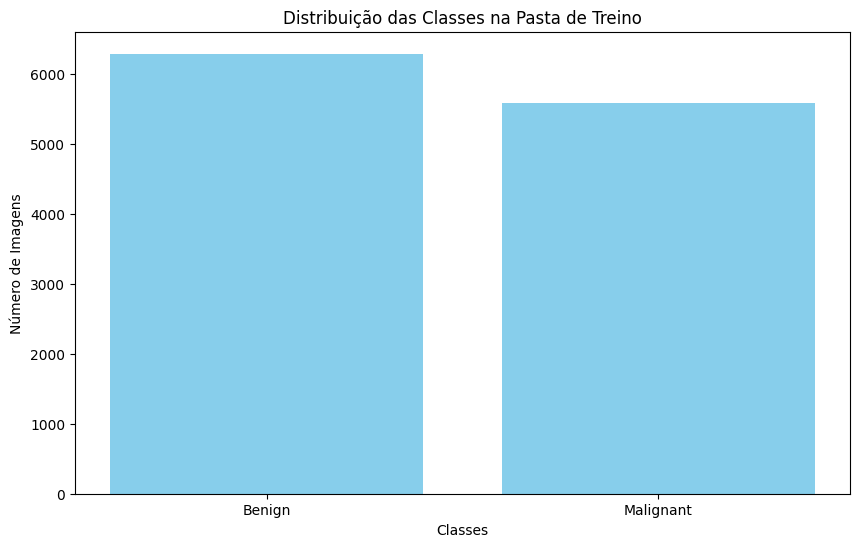

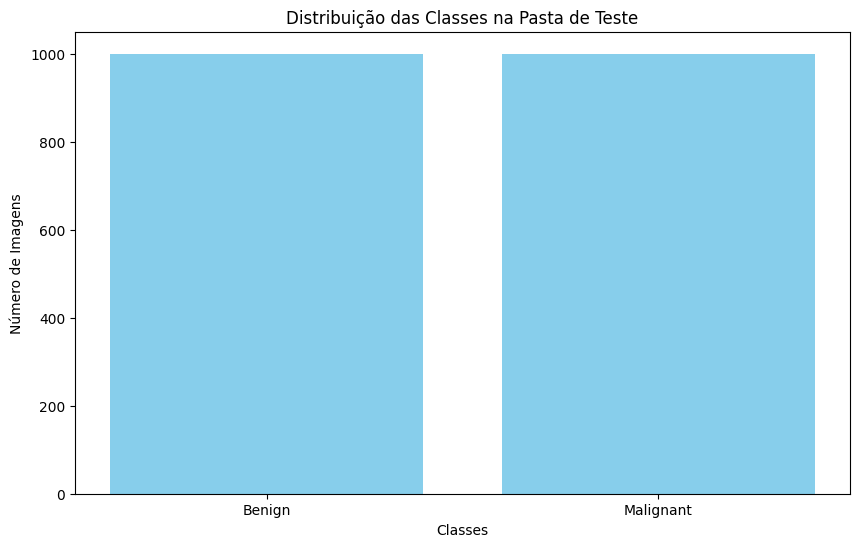

In [13]:
def get_class_distribution(directory):
    class_distribution = {}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)
        class_distribution[class_name] = len(image_files)
    
    return class_distribution

def plot_class_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Número de Imagens')
    plt.title(title)
    plt.show()

# Verificar a distribuição das classes nos diretórios de treino e teste
train_distribution = get_class_distribution(train_dir)
test_distribution = get_class_distribution(test_dir)

# Exibir resultados
print(f"Distribuição das classes na pasta de treino: {train_distribution}")
print(f"Distribuição das classes na pasta de teste: {test_distribution}")

# Plotar gráficos de distribuição
plot_class_distribution(train_distribution, 'Distribuição das Classes na Pasta de Treino')
plot_class_distribution(test_distribution, 'Distribuição das Classes na Pasta de Teste')


### Perguntei ou gepeto se este desequilibrio poderia causar problemas no treino do modelo posteriormente e o que fazer
#### Análise do Desequilíbrio

**Distribuição Observada:**
- **Treino:**
  - `Benign`: 6289 imagens
  - `Malignant`: 5590 imagens
- **Teste:**
  - `Benign`: 1000 imagens
  - `Malignant`: 1000 imagens

**Desequilíbrio no Treino:**
- A diferença entre o número de imagens das classes `Benign` e `Malignant` no conjunto de treino é de 699 imagens.
- Percentualmente, isso representa aproximadamente 5,6% de diferença entre as duas classes.

### Impacto Potencial

1. **Modelagem e Treinamento:**
   - **Classificação Desbalanceada**: Um pequeno desequilíbrio pode não ser um problema grave, mas pode afetar o desempenho do modelo. Modelos de aprendizado de máquina tendem a ser mais sensíveis a desequilíbrios de classe quando a diferença é significativa.
   - **Bias do Modelo**: O modelo pode desenvolver um viés em direção à classe com mais imagens, o que pode resultar em uma menor performance na classe minoritária.

2. **Métricas de Avaliação:**
   - **Acurácia**: Pode ser enganosa em conjuntos de dados desbalanceados. Mesmo que o modelo tenha uma alta acurácia, isso não garante uma boa performance em todas as classes.
   - **Outras Métricas**: Métricas como precisão, recall e F1-score podem fornecer uma visão mais clara do desempenho do modelo, especialmente para a classe minoritária.

### Estratégias para Lidar com Desequilíbrios

Se você decidir que o desequilíbrio pode afetar o treinamento do seu modelo, aqui estão algumas estratégias que você pode considerar:

1. **Reamostragem:**
   - **Oversampling**: Aumentar o número de exemplos na classe minoritária (por exemplo, duplicando imagens ou gerando novas imagens sintéticas).
   - **Undersampling**: Reduzir o número de exemplos na classe majoritária.

2. **Ajuste de Pesos:**
   - Ajustar os pesos das classes no modelo para penalizar mais erros na classe minoritária.

3. **Aumento de Dados:**
   - Aplicar técnicas de aumento de dados (data augmentation) para a classe minoritária para criar variações das imagens existentes.

4. **Validação Cruzada:**
   - Utilizar técnicas de validação cruzada para garantir que o modelo generalize bem para diferentes divisões dos dados.

5. **Métricas de Avaliação:**
   - Focar em métricas mais informativas como F1-score, precision-recall curve e ROC curve, que podem dar uma melhor indicação do desempenho do modelo nas diferentes classes.

### Conclusão

Embora o desequilíbrio no conjunto de treino não seja grande, é uma boa prática monitorar como isso pode impactar o desempenho do seu modelo. Implementar algumas das estratégias mencionadas pode ajudar a mitigar o impacto e garantir que o modelo esteja bem equilibrado em relação às classes.

# Verificando Duplicatas

#### Hash MD5
- o que é?

O hash MD5 (Message Digest Algorithm 5) é uma função de hash criptográfico que gera um valor de hash de 128 bits (ou 16 bytes), normalmente representado como uma sequência hexadecimal de 32 dígitos. O MD5 é utilizado para verificar a integridade dos dados, criar assinaturas digitais e identificar de forma única o conteúdo de um arquivo ou mensagem.

Características do MD5
Determinístico: Para um dado específico de entrada, o hash MD5 sempre gera o mesmo valor de hash.
Rapidez: O cálculo do hash MD5 é muito rápido, tornando-o eficiente para processamento de grandes quantidades de dados.
Comprimento Fixado: Independentemente do tamanho da entrada, o valor de hash MD5 sempre terá 128 bits (32 caracteres hexadecimais).
Unicidade: Idealmente, duas entradas diferentes não devem gerar o mesmo valor de hash (uma propriedade chamada de "pre-image resistance"). No entanto, devido a coligações descobertas, isso não é garantido em todos os casos.
Usos Comuns
Verificação de Integridade: O MD5 é frequentemente utilizado para verificar se os arquivos foram corrompidos ou alterados. Por exemplo, ao baixar um arquivo, você pode comparar o hash MD5 do arquivo baixado com o hash fornecido pelo site para garantir que o arquivo está intacto.
Identificação de Arquivos: Ao calcular o hash MD5 de um arquivo, você pode identificar arquivos duplicados com base na comparação dos valores de hash.

In [14]:
def calculate_md5(image_path):
    #Calcula o hash MD5 de uma imagem.
    hash_md5 = hashlib.md5()
    with open(image_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_duplicate_images(directory):
    image_hashes = {}
    duplicates = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue
        
        image_files = os.listdir(class_dir)

        for image_name in image_files:
            image_path = os.path.join(class_dir, image_name)
            
            try:
                image_hash = calculate_md5(image_path)
                if image_hash in image_hashes:
                    duplicates.append({
                        'image_name': image_name,
                        'class': class_name,
                        'duplicate_of': image_hashes[image_hash]
                    })
                else:
                    image_hashes[image_hash] = image_name
            except Exception as e:
                print(f"Erro ao processar {image_name}: {e}")

    return duplicates

# Verifica duplicatas nos diretórios de treino e teste
duplicates_train = find_duplicate_images(train_dir)
duplicates_test = find_duplicate_images(test_dir)

# exibe resultados
print(f"Imagens duplicadas na pasta de treino: {duplicates_train}")
print(f"Imagens duplicadas na pasta de teste: {duplicates_test}")

Imagens duplicadas na pasta de treino: []
Imagens duplicadas na pasta de teste: []


Pode-se concluir com o código acima que não há imagens duplicadas.

# Informações complementares

- Elaborar uma apresentação para mostrar os resultados.
- Apresentar o dataset de forma detalhada.
- Verifique quais itens em Informações esperadas podem ser aplicados no
dataset.